# Милютина Лилия

In [1]:
import time
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from tqdm import tqdm

In [2]:
path = 'rekko/ratings.csv'
df = pd.read_csv(path)
df = df.iloc[:1000, :]

**Посмотрим на данные**

In [3]:
df.head()

,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07
3,359870,1364,10,4.430506e+07
4,359870,3578,9,4.430506e+07


**Создадим NCF модель**

In [4]:
class NCF(nn.Module):
    def __init__(self, user_num, item_num, factor_num, num_layers, type_non_linear='relu'):
        super(NCF, self).__init__()
        
        # Эмбеддинги user-ов и item-ов.
        self.embed_user = nn.Embedding(user_num, factor_num * (2 ** (num_layers - 1)))
        self.embed_item = nn.Embedding(item_num, factor_num * (2 ** (num_layers - 1)))
        
        # Собираем слои.
        modules = []
        for i in range(num_layers):
            input_size = factor_num * (2 ** (num_layers - i))
            modules.append(nn.Linear(input_size, input_size//2))
            
            if type_non_linear == 'relu':
                modules.append(nn.ReLU())
            elif type_non_linear == 'leaky-relu':
                modules.append(nn.LeakyReLU())
            elif type_non_linear == 'relu6':
                modules.append(nn.ReLU6())
            elif type_non_linear == 'selu':
                modules.append(nn.SELU())
            elif type_non_linear == 'celu':
                modules.append(nn.CELU())
            else:
                print('Unknown non-linear activation.')
        
        # Заворачиваем в контейнер.
        self.layers = nn.Sequential(*modules)
        self.predict_layer = nn.Linear(factor_num, 1)
        
        # Инициализация.
        self._init_weight_()
        
    def _init_weight_(self):
        """
        Инициализация весов.
        """
        nn.init.normal_(self.embed_user.weight, std=0.01)
        nn.init.normal_(self.embed_item.weight, std=0.01)

        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        nn.init.kaiming_uniform_(self.predict_layer.weight, a=1, nonlinearity='sigmoid')

        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user, item):
        embed_user = self.embed_user(user)
        embed_item = self.embed_item(item)
        interaction = torch.cat((embed_user, embed_item), -1)
        output = self.layers(interaction)
        prediction = self.predict_layer(output)
        return prediction.view(-1)

**Создадим DataSet для обертки датафрейма**

In [5]:
class NCFData(data.Dataset):
    def __init__(self, features, num_item, matrix=None):
        super(NCFData, self).__init__()
        self.features = features
        self.num_item = num_item
        self.matrix = matrix
        self.labels = [matrix.todense()[el[0], el[1]] for el in features]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]
        return user, item, label

*Нужная функция collate для правильной работы DataLoader*

In [6]:
def collate(batch):
    users = []
    items = []
    labels = []
    for item in batch:
        user, item, label = item
        users.append(user)
        items.append(item)
        labels.append(label)
    return torch.tensor(users, dtype=torch.int64), torch.tensor(items, dtype=torch.int64), torch.tensor(labels, dtype=torch.float64)

**Функции для расчета метрик: RMSE и nDCG@n**

In [7]:
def rmse(y_1, y_2):
    y_1_ = y_1.detach().numpy()
    y_2_ = y_2.detach().numpy()
    return ((y_1_ - y_2_) ** 2).mean() ** .5


def ndcg(gt_item, pred_items):
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index+2))
    return 0


def get_metrics(model, test_loader, top_k):
    NDCG, RMSE = [], []

    for user, item, label in test_loader:

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).numpy().tolist()

        gt_item = item[0].item()

        NDCG.append(ndcg(gt_item, recommends))
        RMSE.append(rmse(predictions, label))

    return np.mean(NDCG), np.mean(RMSE)

In [8]:
def load(df):
    user_num = df['user_uid'].max() + 1
    item_num = df['element_uid'].max() + 1
    
    matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for i in tqdm(range(df.shape[0])):
        user_id = df.iloc[i, :]['user_uid']
        item_id = df.iloc[i, :]['element_uid']
        rating = df.iloc[i, :]['rating']
        matrix[user_id, item_id] = rating

    return df.iloc[:, :2].values.tolist(), user_num, item_num, matrix

**Функция для тренировки и оценки НС при кросс-валидации**

In [9]:
def train(model, optimizer, dataset, n_epochs):
    
    all_ndcg_metrics = []
    all_rmse_metrics = []
    
    splits = KFold(n_splits=3, shuffle=True, random_state=42)
    loss_function = nn.BCEWithLogitsLoss()
    for fold, (train_ids, test_ids) in enumerate(splits.split(dataset)):

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        trainloader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=batch_size, sampler=train_subsampler, collate_fn=collate)
        testloader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=batch_size, sampler=test_subsampler, collate_fn=collate)
        
        ndcg_metrics, rmse_metrics = [], []
        for epoch in range(n_epochs):
            model.train()
            start_time = time.time()

            for i, (user, item, label) in enumerate(trainloader):
                model.zero_grad()
                prediction = model(user, item)
                loss = loss_function(prediction, label)
                loss.backward()
                optimizer.step()

            model.eval()
            NDCG, RMSE = get_metrics(model, testloader, top_k)
            ndcg_metrics.append(round(np.mean(NDCG),3))
            rmse_metrics.append(round(np.mean(RMSE),3))
        
        all_ndcg_metrics.append(np.max(ndcg_metrics))
        all_rmse_metrics.append(np.min(rmse_metrics))
        
    return np.mean(all_ndcg_metrics), np.mean(all_rmse_metrics)

In [10]:
n_epochs = 10
factor_num = 5
top_k = 5
batch_size = 100

In [11]:
ready_data, user_num, item_num, matrix = load(df)
dataset = NCFData(ready_data, item_num, matrix)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1858.94it/s]


# Эксперименты с разными нелинейными функциями активации

In [12]:
type_non_linear_acts = ['relu', 'leaky-relu', 'relu6', 'selu', 'celu']
all_num_layers = [3, 5]

all_results_rmse = []
all_results_ndcg = []
for num_layers in all_num_layers:
    results_rmse = []
    results_ndcg = []
    for type_non_linear_act in type_non_linear_acts:
        model = NCF(user_num, item_num, factor_num, num_layers, type_non_linear=type_non_linear_act)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        best_ndcg, best_rmse = train(model, optimizer, dataset, n_epochs)
        
        results_ndcg.append(best_ndcg)
        results_rmse.append(best_rmse)
            
        print(f'Number of layers: {num_layers}, Non-linear activation: {type_non_linear_act}, RMSE: {round(best_rmse)}, nDCG@5: {round(best_ndcg,3)}')
    
    print('-------')
    all_results_rmse.append(results_rmse)
    all_results_ndcg.append(results_ndcg)

Number of layers: 3, Non-linear activation: relu, RMSE: 8, nDCG@5: 0.23
Number of layers: 3, Non-linear activation: leaky-relu, RMSE: 12, nDCG@5: 0.208
Number of layers: 3, Non-linear activation: relu6, RMSE: 6, nDCG@5: 0.494
Number of layers: 3, Non-linear activation: selu, RMSE: 13, nDCG@5: 0.219
Number of layers: 3, Non-linear activation: celu, RMSE: 8, nDCG@5: 0.224
Number of layers: 5, Non-linear activation: relu, RMSE: 8, nDCG@5: 1.0
Number of layers: 5, Non-linear activation: leaky-relu, RMSE: 5462, nDCG@5: 0.167
Number of layers: 5, Non-linear activation: relu6, RMSE: 6, nDCG@5: 0.75
Number of layers: 5, Non-linear activation: selu, RMSE: 74, nDCG@5: 0.314
Number of layers: 5, Non-linear activation: celu, RMSE: 4808, nDCG@5: 0.333


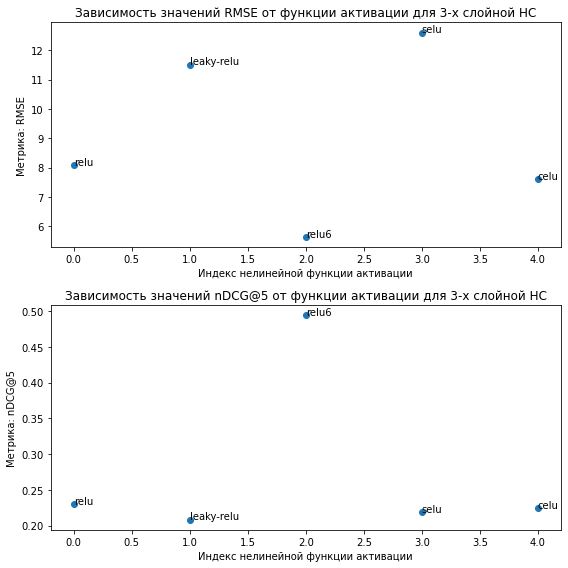

In [13]:
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(len(type_non_linear_acts)), all_results_rmse[0], 'o')
for i, name in enumerate(type_non_linear_acts):
    ax1.annotate(name, xy=(i, all_results_rmse[0][i]))

ax1.set_xlabel('Индекс нелинейной функции активации')
ax1.set_ylabel('Метрика: RMSE')
ax1.set_title('Зависимость значений RMSE от функции активации для 3-x слойной НС')

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(len(type_non_linear_acts)), all_results_ndcg[0], 'o')
for i, name in enumerate(type_non_linear_acts):
    ax2.annotate(name, xy=(i, all_results_ndcg[0][i]))

ax2.set_xlabel('Индекс нелинейной функции активации')
ax2.set_ylabel('Метрика: nDCG@5')
ax2.set_title('Зависимость значений nDCG@5 от функции активации для 3-x слойной НС')

fig.tight_layout()

plt.show()

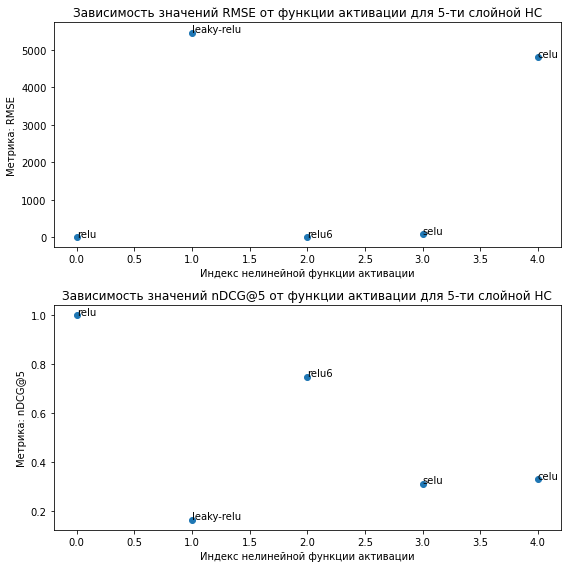

In [14]:
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(len(type_non_linear_acts)), all_results_rmse[1], 'o')
for i, name in enumerate(type_non_linear_acts):
    ax1.annotate(name, xy=(i, all_results_rmse[1][i]))

ax1.set_xlabel('Индекс нелинейной функции активации')
ax1.set_ylabel('Метрика: RMSE')
ax1.set_title('Зависимость значений RMSE от функции активации для 5-ти слойной НС')

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(len(type_non_linear_acts)), all_results_ndcg[1], 'o')
for i, name in enumerate(type_non_linear_acts):
    ax2.annotate(name, xy=(i, all_results_ndcg[1][i]))

ax2.set_xlabel('Индекс нелинейной функции активации')
ax2.set_ylabel('Метрика: nDCG@5')
ax2.set_title('Зависимость значений nDCG@5 от функции активации для 5-ти слойной НС')

fig.tight_layout()

plt.show()

**Выводы:**   

- Лучше всего себя показала нелинейная функция активации: ReLU6, как в случае 3-х, так и 5-ти слойной НС

- Значения метрик при 5-ти слоях лучше, чем при 3-х (что совпадает с теоретическими представлениями)

# Эксперименты с разным числом скрытых латентных факторов

*Функцию активации зафиксируем ReLU6 как лучше всего себя показавшую в прошлом эксперименте*

In [15]:
factor_nums = [5, 10, 20, 30, 50]

all_results_rmse = []
all_results_ndcg = []
for num_layers in all_num_layers:
    results_rmse = []
    results_ndcg = []
    for factor_num in factor_nums:
        model = NCF(user_num, item_num, factor_num, num_layers, type_non_linear='relu6')
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        best_ndcg, best_rmse = train(model, optimizer, dataset, n_epochs)
        
        results_rmse.append(best_rmse)
        results_ndcg.append(best_ndcg)
            
        print(f'Number of layers: {num_layers}, Number of factors: {factor_num}, RMSE: {round(best_rmse)}, nDCG@5: {round(best_ndcg,3)}')
    
    all_results_rmse.append(results_rmse)
    all_results_ndcg.append(results_ndcg)

Number of layers: 3, Number of factors: 5, RMSE: 4, nDCG@5: 0.532
Number of layers: 3, Number of factors: 10, RMSE: 4, nDCG@5: 0.719
Number of layers: 3, Number of factors: 20, RMSE: 11, nDCG@5: 0.833
Number of layers: 3, Number of factors: 30, RMSE: 14, nDCG@5: 0.917
Number of layers: 3, Number of factors: 50, RMSE: 26, nDCG@5: 0.917
Number of layers: 5, Number of factors: 5, RMSE: 3, nDCG@5: 0.668
Number of layers: 5, Number of factors: 10, RMSE: 6, nDCG@5: 0.917
Number of layers: 5, Number of factors: 20, RMSE: 6, nDCG@5: 1.0
Number of layers: 5, Number of factors: 30, RMSE: 10, nDCG@5: 0.75
Number of layers: 5, Number of factors: 50, RMSE: 10, nDCG@5: 1.0


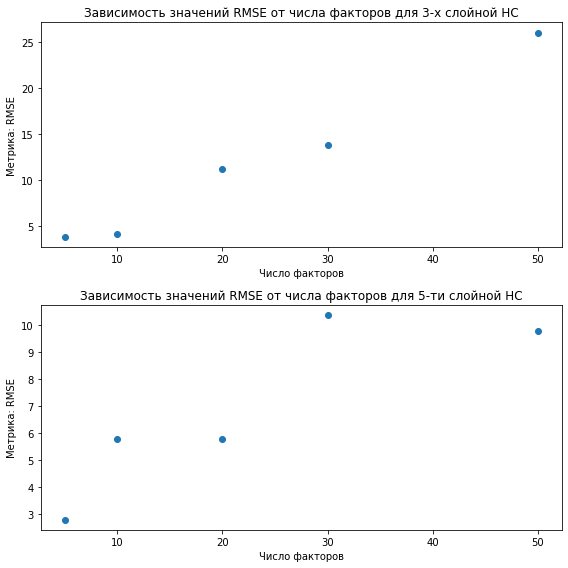

In [18]:
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(211)
ax1.plot(factor_nums, all_results_rmse[0], 'o')
ax1.set_xlabel('Число факторов')
ax1.set_ylabel('Метрика: RMSE')
ax1.set_title('Зависимость значений RMSE от числа факторов для 3-x слойной НС')

ax2 = fig.add_subplot(212)
ax2.plot(factor_nums, all_results_rmse[1], 'o')
ax2.set_xlabel('Число факторов')
ax2.set_ylabel('Метрика: RMSE')
ax2.set_title('Зависимость значений RMSE от числа факторов для 5-ти слойной НС')

fig.tight_layout()

plt.show()

**Выводы**:   
- 5 факторов - оптимальный параметр для 3-х слойной и 5-ти слойной НС (однако, возможно, если сделать больше эпох обучения, то при большем числе факторов будет лучше, но всю GPU на Colab-e я уже потратила на курс DL:))  
- Значения метрики при 5-ти слоях лучше, чем при 3-х (что совпадает с теоретическими представлениями)

# Общие выводы:

- Была реализована модель NCF на PyTorch
- Проведены эксперименты с числом слоев (3 и 5): 5-ти слойная НС показывает лучшее качество (RMSE и nDCG метрики)
- По кросс-валидации по метрике RMSE выбрана функция активации ReLu6
- Проведены эксперименты с количеством латентных факторов (при 5 латентных факторах значение метрики RMSE лучшее)